<a href="https://colab.research.google.com/github/Michael-David-Lam/NLP-Final-Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries/Dependencies Installation

In [2]:
# !pip install datasets
# !pip install gensim
# !pip install --upgrade numpy gensim
# !pip install tensorflow
# !pip install seqeval
# !pip uninstall -y torch torchtext
# !pip install torch==2.0.1 torchtext==0.15.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16164 sha256=f8c06d192c4f10aaa33bb3b3e09219b34337b44f536610895574e15195570b89
  Stored in directory: /Users/darren/Library/Caches/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
Found existing installation: torch 2.4.1
Uninstalling torch-2.4.1:
  Successfully uninstalled torch-2.4.1
  Obtaining dependency information for torch==2.0.1 from https://files.pythonhosted.org/packages/85/68/f901437d3e3ef6fe97adb1f372479626d994185b8fa06803f5bdf3bb90fd/torch-2.0.1-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchtext==0.15.2 from https://files.pythonhosted.org/packages/59/e9/1d3ecd04ef057277ba7e3ad0b8793f0d161b60a4ba7fe0b9aa6870a498e4/torchtext-0.15.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining depe

# Setup 1 (Word2Vec)

In [32]:
import pandas as pd
import numpy as np
import ast
import string
from itertools import chain
from collections import Counter

from datasets import load_dataset
import evaluate
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec, KeyedVectors

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer

import matplotlib.pyplot as plt
import seaborn as sns


In [52]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [53]:
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [54]:
#To combine train,test,split for vectorisation to build a rich embedding space

import ast

def safe_parse(col):
    return [ast.literal_eval(row) if isinstance(row, str) else row for row in col]

train_tokens = safe_parse(df_train["tokens"])
val_tokens = safe_parse(df_val["tokens"])
test_tokens = safe_parse(df_test["tokens"])

all_tokens = train_tokens + val_tokens + test_tokens

In [55]:
#List of Parameters (Just using Lab as reference)
num_features = 300
min_word_count = 1
num_workers = 2
window_size = 3
subsampling = 1e-3

In [56]:
w2v_model = Word2Vec(
    sentences=all_tokens,
    vector_size=num_features,
    window=window_size,
    min_count=min_word_count,
    workers=num_workers,
    sample=subsampling
)

In [57]:
vocab = w2v_model.wv.index_to_key
word_index = {word: idx + 1 for idx, word in enumerate(vocab)}

embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [58]:
all_lengths = [len(seq) for seq in train_tokens + val_tokens + test_tokens]

print(max(all_lengths))
print(np.mean(all_lengths))
print(np.percentile(all_lengths, 90))
#likelihood to chose 76 to get the best balance of computational power + covers 90% of sequence

371
41.17041666666667
76.0


In [59]:
# Encode as Bi-LSTM requires numbers to process

def encode_sentences(token_lists, word_index, max_len):
    sequences = [[word_index.get(token, 0) for token in tokens] for tokens in token_lists]
    return pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

#using 90th percentile first
max_len = 76

X_train = encode_sentences(train_tokens, word_index, max_len)
X_val = encode_sentences(val_tokens, word_index, max_len)
X_test = encode_sentences(test_tokens, word_index, max_len)

In [60]:
all_tags = df_train["ner_tags"].tolist() + df_val["ner_tags"].tolist() + df_test["ner_tags"].tolist()

tag_encoder = LabelEncoder()
tag_encoder.fit([tag for seq in all_tags for tag in seq])
num_classes = len(tag_encoder.classes_)

def encode_tags(tag_lists, max_len):
    encoded = [tag_encoder.transform(tags) for tags in tag_lists]
    padded = pad_sequences(encoded, maxlen=max_len, padding="post", truncating="post", value=-1)  # -1 for masking
    return padded

y_train = encode_tags(df_train["ner_tags"].tolist(), max_len)
y_val = encode_tags(df_val["ner_tags"].tolist(), max_len)
y_test = encode_tags(df_test["ner_tags"].tolist(), max_len)

In [61]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=max_len,
                  mask_zero=True,
                  trainable=True)(input)
model = Bidirectional(LSTM(units=128, return_sequences=True))(model)
model = Dense(num_classes, activation="softmax")(model)

model = Model(input, model)
model.summary()

/Users/darren/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 76, 300)   │  4,947,600 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 76)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 76, 256)   │    439,296 │ embedding_5[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 76, 4)     │      1,028 │ bidirectional_3[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,387,924 (20.55 MB)

 Trainable params: 5,387,924 (20.55 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
def create_sample_weights(y_padded):
    return (y_padded != -1).astype("float32")

sample_weights_train = create_sample_weights(y_train)
sample_weights_val = create_sample_weights(y_val)

y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)

In [63]:
#Training of model (using Adam as a baseline optimiser)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train[..., np.newaxis],
    validation_data=(X_val, y_val[..., np.newaxis], sample_weights_val),
    sample_weight=sample_weights_train,
    batch_size=32,
    epochs=15
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.3890 - loss: 0.8189 - val_accuracy: 0.4096 - val_loss: 0.4819
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.4221 - loss: 0.4087 - val_accuracy: 0.4260 - val_loss: 0.3924
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.4590 - loss: 0.2478 - val_accuracy: 0.4327 - val_loss: 0.3628
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.4738 - loss: 0.1461 - val_accuracy: 0.4346 - val_loss: 0.3708
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.4889 - loss: 0.0862 - val_accuracy: 0.4306 - val_loss: 0.4168
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.4920 - loss: 0.0568 - val_accuracy: 0.4254 - val_loss: 0.4991
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.4908 - loss: 0.0387 - val_accuracy: 0.4277 - val_loss: 0.4985
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.5001 - loss: 0.0277 - val_accurac

In [64]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=-1)

idx2tag = {i: t for i, t in enumerate(tag_encoder.classes_)}

true_labels = [[idx2tag[idx] for idx in row if idx != -1] for row in y_test]
pred_labels = [[idx2tag[idx] for idx in row[:len(true_labels[i])]] for i, row in enumerate(y_pred_labels)]

print("F1 Score:", f1_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
F1 Score: 0.6437908496732027
              precision    recall  f1-score   support

          AC       0.74      0.72      0.73       741
          LF       0.48      0.56      0.52       455

   micro avg       0.63      0.66      0.64      1196
   macro avg       0.61      0.64      0.62      1196
weighted avg       0.64      0.66      0.65      1196



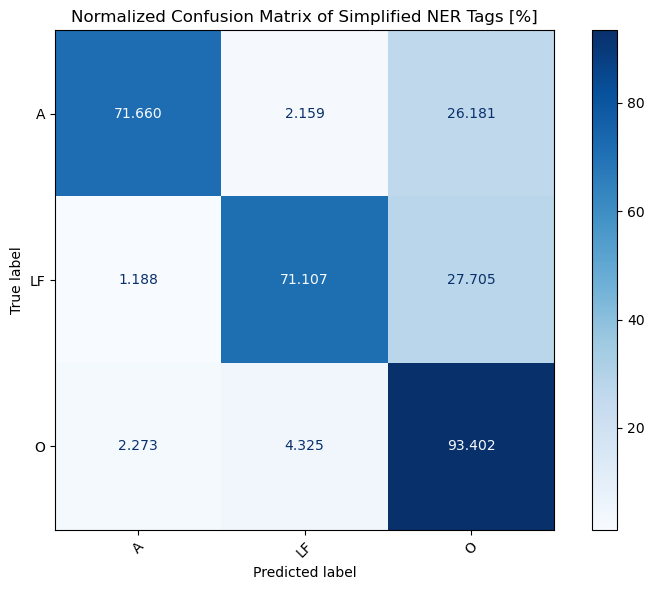

In [65]:

flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in pred_labels for label in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".3f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()


# Set up 2 (Glove)

In [66]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [67]:
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [68]:
def safe_parse(col):
    return [ast.literal_eval(row) if isinstance(row, str) else row for row in col]

train_tokens = safe_parse(df_train["tokens"])
val_tokens = safe_parse(df_val["tokens"])
test_tokens = safe_parse(df_test["tokens"])

all_tokens = train_tokens + val_tokens + test_tokens

In [69]:
from torchtext.vocab import GloVe


glove = GloVe(name='6B', dim=300)

In [70]:
vocab = set(token for sentence in train_tokens + val_tokens + test_tokens for token in sentence)
word_index = {word: i + 1 for i, word in enumerate(vocab)}

embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in glove.stoi:
        embedding_matrix[i] = glove[word].numpy()

In [71]:
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=True
)

In [72]:
def encode_sentences(token_lists, word_index, max_len):
    sequences = [[word_index.get(token, 0) for token in tokens] for tokens in token_lists]
    return pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

#using 90th percentile first
max_len = 76

X_train = encode_sentences(train_tokens, word_index, max_len)
X_val = encode_sentences(val_tokens, word_index, max_len)
X_test = encode_sentences(test_tokens, word_index, max_len)

In [73]:
all_tags = df_train["ner_tags"].tolist() + df_val["ner_tags"].tolist() + df_test["ner_tags"].tolist()

tag_encoder = LabelEncoder()
tag_encoder.fit([tag for seq in all_tags for tag in seq])
num_classes = len(tag_encoder.classes_)

def encode_tags(tag_lists, max_len):
    encoded = [tag_encoder.transform(tags) for tags in tag_lists]
    padded = pad_sequences(encoded, maxlen=max_len, padding="post", truncating="post", value=-1)  # -1 for masking
    return padded

y_train = encode_tags(df_train["ner_tags"].tolist(), max_len)
y_val = encode_tags(df_val["ner_tags"].tolist(), max_len)
y_test = encode_tags(df_test["ner_tags"].tolist(), max_len)

In [74]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=max_len,
                  mask_zero=True,
                  trainable=True)(input)
model = Bidirectional(LSTM(units=128, return_sequences=True))(model)
model = Dense(num_classes, activation="softmax")(model)

model = Model(input, model)
model.summary()

/Users/darren/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 76, 300)   │  4,947,600 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 76)        │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 76, 256)   │    439,296 │ embedding_7[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 76, 4)     │      1,028 │ bidirectional_4[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,387,924 (20.55 MB)

 Trainable params: 5,387,924 (20.55 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
def create_sample_weights(y_padded):
    return (y_padded != -1).astype("float32")

sample_weights_train = create_sample_weights(y_train)
sample_weights_val = create_sample_weights(y_val)

y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)

In [76]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train[..., np.newaxis],
    validation_data=(X_val, y_val[..., np.newaxis], sample_weights_val),
    sample_weight=sample_weights_train,
    batch_size=32,
    epochs=15
)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.4041 - loss: 0.7267 - val_accuracy: 0.4146 - val_loss: 0.4189
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.4310 - loss: 0.3443 - val_accuracy: 0.4275 - val_loss: 0.3529
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.4526 - loss: 0.2466 - val_accuracy: 0.4340 - val_loss: 0.3371
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.4735 - loss: 0.1551 - val_accuracy: 0.4339 - val_loss: 0.3471
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.4755 - loss: 0.1002 - val_accuracy: 0.4327 - val_loss: 0.3766
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.4946 - loss: 0.0636 - val_accuracy: 0.4327 - val_loss: 0.4110
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.4949 - loss: 0.0382 - val_accuracy: 0.4321 - val_loss: 0.4546
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.4970 - loss: 0.0283 - val_accuracy: 0.

In [77]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=-1)

idx2tag = {i: t for i, t in enumerate(tag_encoder.classes_)}

true_labels = [[idx2tag[idx] for idx in row if idx != -1] for row in y_test]
pred_labels = [[idx2tag[idx] for idx in row[:len(true_labels[i])]] for i, row in enumerate(y_pred_labels)]

print("F1 Score:", f1_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
F1 Score: 0.676973148901546
              precision    recall  f1-score   support

          AC       0.76      0.75      0.76       741
          LF       0.52      0.60      0.56       455

   micro avg       0.66      0.70      0.68      1196
   macro avg       0.64      0.68      0.66      1196
weighted avg       0.67      0.70      0.68      1196



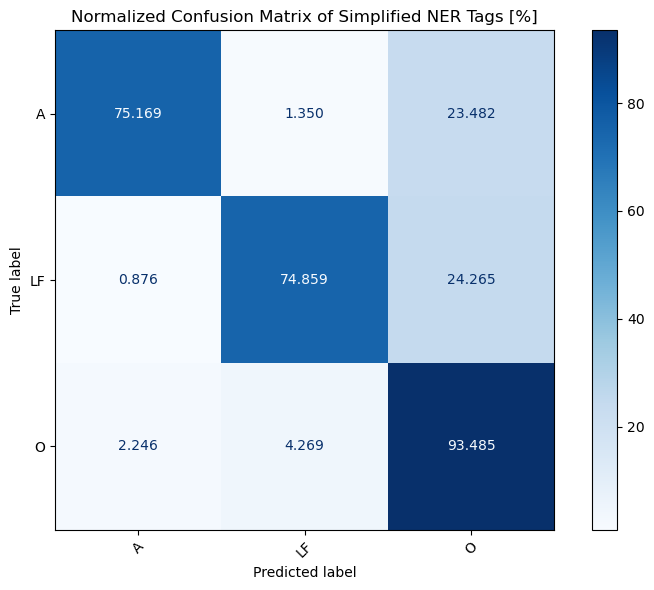

In [78]:

flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in pred_labels for label in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".3f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()


# Set up 3 (Fast Text)

In [36]:
from torchtext.vocab import FastText

fasttext = FastText(language='en')

.vector_cache/wiki.en.vec: 6.60GB [18:06, 6.07MB/s]                             
100%|██████████████████████████████| 2519370/2519370 [01:54<00:00, 21954.82it/s]


In [37]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [38]:
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [39]:
#To combine train,test,split for vectorisation to build a rich embedding space

def safe_parse(col):
    return [ast.literal_eval(row) if isinstance(row, str) else row for row in col]

train_tokens = safe_parse(df_train["tokens"])
val_tokens = safe_parse(df_val["tokens"])
test_tokens = safe_parse(df_test["tokens"])

all_tokens = train_tokens + val_tokens + test_tokens

Preparation of data (Creating vocab + embeding matrix from model itself)

In [40]:
vocab = set(token for sentence in train_tokens + val_tokens + test_tokens for token in sentence)
word_index = {word: i + 1 for i, word in enumerate(vocab)}

embedding_dim = fasttext.dim
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in fasttext.stoi:
        embedding_matrix[i] = fasttext[word].numpy()

In [41]:
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=True
)


In [42]:
# Encode as Bi-LSTM requires numbers to process
def encode_sentences(token_lists, word_index, max_len):
    sequences = [[word_index.get(token, 0) for token in tokens] for tokens in token_lists]
    return pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

#using 90th percentile first
max_len = 76

X_train = encode_sentences(train_tokens, word_index, max_len)
X_val = encode_sentences(val_tokens, word_index, max_len)
X_test = encode_sentences(test_tokens, word_index, max_len)

In [43]:
all_tags = df_train["ner_tags"].tolist() + df_val["ner_tags"].tolist() + df_test["ner_tags"].tolist()

tag_encoder = LabelEncoder()
tag_encoder.fit([tag for seq in all_tags for tag in seq])
num_classes = len(tag_encoder.classes_)

def encode_tags(tag_lists, max_len):
    encoded = [tag_encoder.transform(tags) for tags in tag_lists]
    padded = pad_sequences(encoded, maxlen=max_len, padding="post", truncating="post", value=-1)  # -1 for masking
    return padded

y_train = encode_tags(df_train["ner_tags"].tolist(), max_len)
y_val = encode_tags(df_val["ner_tags"].tolist(), max_len)
y_test = encode_tags(df_test["ner_tags"].tolist(), max_len)

In [44]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=embedding_matrix.shape[0],
                  output_dim=embedding_matrix.shape[1],
                  weights=[embedding_matrix],
                  input_length=max_len,
                  mask_zero=True,
                  trainable=True)(input)
model = Bidirectional(LSTM(units=128, return_sequences=True))(model)
model = Dense(num_classes, activation="softmax")(model)

model = Model(input, model)
model.summary()


/Users/darren/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 76, 300)   │  4,947,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 76)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 76, 256)   │    439,296 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 76, 4)     │      1,028 │ bidirectional_2[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,387,924 (20.55 MB)

 Trainable params: 5,387,924 (20.55 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
def create_sample_weights(y_padded):
    return (y_padded != -1).astype("float32")

sample_weights_train = create_sample_weights(y_train)
sample_weights_val = create_sample_weights(y_val)

y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)



In [46]:
#Training of model (using Adam as a baseline optimiser)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train[..., np.newaxis],
    validation_data=(X_val, y_val[..., np.newaxis], sample_weights_val),
    sample_weight=sample_weights_train,
    batch_size=32,
    epochs=15
)


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.3889 - loss: 0.8005 - val_accuracy: 0.4154 - val_loss: 0.4243
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.4265 - loss: 0.3423 - val_accuracy: 0.4305 - val_loss: 0.3468
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.4630 - loss: 0.2141 - val_accuracy: 0.4332 - val_loss: 0.3445
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.4729 - loss: 0.1284 - val_accuracy: 0.4329 - val_loss: 0.3567
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.4928 - loss: 0.0795 - val_accuracy: 0.4360 - val_loss: 0.3740
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.4882 - loss: 0.0515 - val_accuracy: 0.4342 - val_loss: 0.4282
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.5005 - loss: 0.0372 - val_accuracy: 0.4343 - val_loss: 0.4523
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.4920 - loss: 0.0256 - val_accurac

In [47]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=-1)

idx2tag = {i: t for i, t in enumerate(tag_encoder.classes_)}

true_labels = [[idx2tag[idx] for idx in row if idx != -1] for row in y_test]
pred_labels = [[idx2tag[idx] for idx in row[:len(true_labels[i])]] for i, row in enumerate(y_pred_labels)]

print("F1 Score:", f1_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
F1 Score: 0.6740924092409241
              precision    recall  f1-score   support

          AC       0.79      0.77      0.78       741
          LF       0.49      0.55      0.52       455

   micro avg       0.67      0.68      0.67      1196
   macro avg       0.64      0.66      0.65      1196
weighted avg       0.67      0.68      0.68      1196



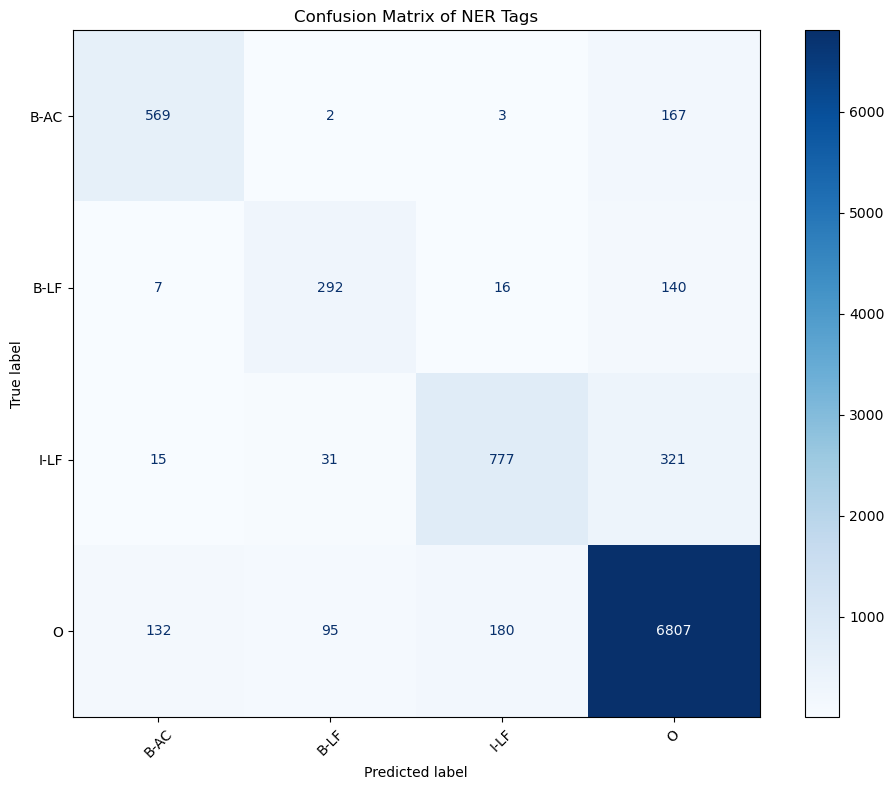

In [48]:
report_dict = classification_report(true_labels, pred_labels,output_dict=True)
class_keys = [key for key in report_dict.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']]

flat_true = [tag for seq in true_labels for tag in seq]
flat_pred = [tag for seq in pred_labels for tag in seq]

flat_pred = flat_pred[:len(flat_true)]

unique_tags = sorted(set(flat_true + flat_pred))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(unique_tags)

y_true_encoded = le.transform(flat_true)
y_pred_encoded = le.transform(flat_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix of NER Tags")
plt.tight_layout()
plt.show()

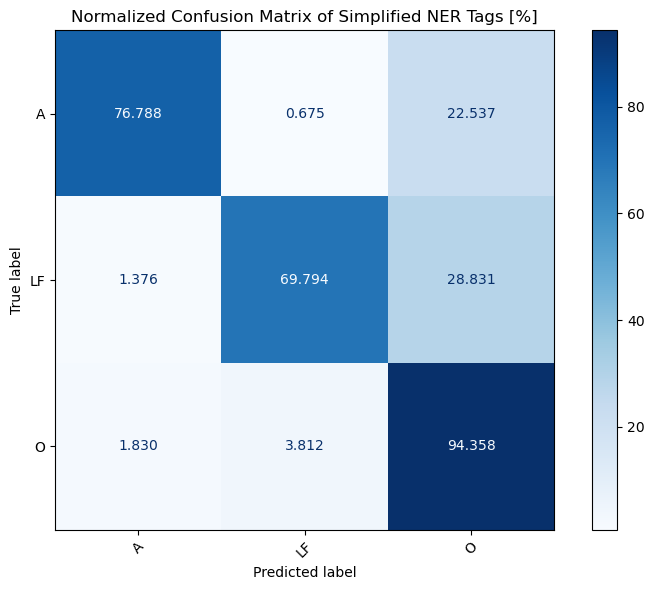

In [50]:
flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in pred_labels for label in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".3f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()


# Experiment 2

Set-up 1: No preprocessing, GloVe/best ex1, RNN + Softmax, F1 metric evaluation

In [1]:
from datasets import load_dataset
import pandas as pd
from gensim.models import Word2Vec
import ast

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [3]:
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [4]:
import ast

def safe_parse(col):
    return [ast.literal_eval(row) if isinstance(row, str) else row for row in col]

train_tokens = safe_parse(df_train["tokens"])
val_tokens = safe_parse(df_val["tokens"])
test_tokens = safe_parse(df_test["tokens"])

all_tokens = train_tokens + val_tokens + test_tokens

In [5]:
type(df_train['tokens'][0])

list

In [6]:
from torchtext.vocab import GloVe


glove = GloVe(name='6B', dim=300)


.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 399999/400000 [01:03<00:00, 6342.34it/s]


Preparation of data (Creating vocab + embeding matrix from model itself)

In [7]:
import numpy as np

vocab = set(token for sentence in train_tokens + val_tokens + test_tokens for token in sentence)
word_index = {word: i + 1 for i, word in enumerate(vocab)}

embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in glove.stoi:
        embedding_matrix[i] = glove[word].numpy()


In [8]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=True
)


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode_sentences(token_lists, word_index, max_len):
    sequences = [[word_index.get(token, 0) for token in tokens] for tokens in token_lists]
    return pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

#using 90th percentile first
max_len = 76

X_train = encode_sentences(train_tokens, word_index, max_len)
X_val = encode_sentences(val_tokens, word_index, max_len)
X_test = encode_sentences(test_tokens, word_index, max_len)

In [10]:
from sklearn.preprocessing import LabelEncoder

all_tags = df_train["ner_tags"].tolist() + df_val["ner_tags"].tolist() + df_test["ner_tags"].tolist()

tag_encoder = LabelEncoder()
tag_encoder.fit([tag for seq in all_tags for tag in seq])
num_classes = len(tag_encoder.classes_)

def encode_tags(tag_lists, max_len):
    encoded = [tag_encoder.transform(tags) for tags in tag_lists]
    padded = pad_sequences(encoded, maxlen=max_len, padding="post", truncating="post", value=-1)  # -1 for masking
    return padded

y_train = encode_tags(df_train["ner_tags"].tolist(), max_len)
y_val = encode_tags(df_val["ner_tags"].tolist(), max_len)
y_test = encode_tags(df_test["ner_tags"].tolist(), max_len)


Change Algorithms RNN Softmax Setup

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, SimpleRNN, LSTM, GRU, Dense, Masking
from tensorflow.keras.utils import to_categorical

input = Input(shape=(max_len,), dtype='int32')

x = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=max_len,
    mask_zero=True,
    trainable=True
)(input)


x = Bidirectional(SimpleRNN(units=128, return_sequences=True))(x)


output = Dense(num_classes, activation="softmax")(x)

model = Model(input, output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 76)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 76, 300)           4947600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 76, 256)          109824    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 76, 4)             1028      
                                                                 
Total params: 5,058,452
Trainable params: 5,058,452
Non-trainable params: 0
_________________________________________________________________


In [14]:
def create_sample_weights(y_padded):
    return (y_padded != -1).astype("float32")

sample_weights_train = create_sample_weights(y_train)
sample_weights_val = create_sample_weights(y_val)

y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)



In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    X_train, y_train[..., np.newaxis],
    validation_data=(X_val, y_val[..., np.newaxis], sample_weights_val),
    sample_weight=sample_weights_train,
    batch_size=32,
    epochs=15
)


In [16]:
from seqeval.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=-1)

idx2tag = {i: t for i, t in enumerate(tag_encoder.classes_)}

true_labels = [[idx2tag[idx] for idx in row if idx != -1] for row in y_test]
pred_labels = [[idx2tag[idx] for idx in row[:len(true_labels[i])]] for i, row in enumerate(y_pred_labels)]

print("F1 Score:", f1_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

8/8 [==============================] - 2s 86ms/step
F1 Score: 0.6522821576763486
              precision    recall  f1-score   support

          AC       0.75      0.72      0.74       741
          LF       0.50      0.55      0.52       455

   micro avg       0.65      0.66      0.65      1196
   macro avg       0.63      0.64      0.63      1196
weighted avg       0.66      0.66      0.66      1196



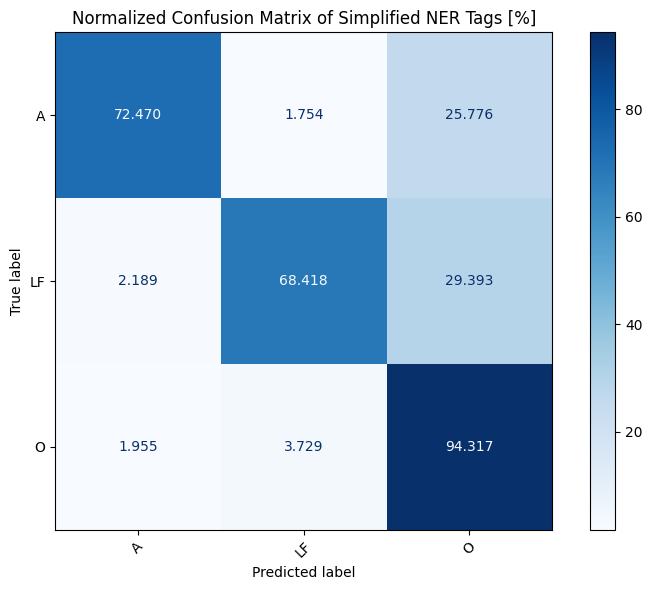

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Flatten true and predicted labels
flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in pred_labels for label in seq]

# Simplify NER tags to 3 classes: A, LF, O
def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

# Label encode the simplified tags
le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

# Normalized confusion matrix (row-wise), then convert to percentage
cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".3f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()


Set-up 2: No preprocessing, GloVe/best ex1, RNN + CRF, F1 metric evaluation


In [ ]:
from datasets import load_dataset
import pandas as pd
from gensim.models import Word2Vec
import ast
from keras_crf import CRFModel
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from datasets import load_dataset
import shutil
import os

cache_dir = os.path.expanduser("~/.cache/huggingface/datasets/surrey-nlp___plod-cw-25")
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [ ]:
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

In [ ]:
import ast

def safe_parse(col):
    return [ast.literal_eval(row) if isinstance(row, str) else row for row in col]

train_tokens = safe_parse(df_train["tokens"])
val_tokens = safe_parse(df_val["tokens"])
test_tokens = safe_parse(df_test["tokens"])

all_tokens = train_tokens + val_tokens + test_tokens

In [ ]:
type(df_train['tokens'][0])

list

In [9]:
from torchtext.vocab import GloVe


glove = GloVe(name='6B', dim=300)


100%|█████████▉| 399999/400000 [01:02<00:00, 6406.31it/s]


Preparation of data (Creating vocab + embeding matrix from model itself)

In [10]:
import numpy as np

vocab = set(token for sentence in train_tokens + val_tokens + test_tokens for token in sentence)
word_index = {word: i + 1 for i, word in enumerate(vocab)}

embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in glove.stoi:
        embedding_matrix[i] = glove[word].numpy()


In [11]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=True
)


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode_sentences(token_lists, word_index, max_len):
    sequences = [[word_index.get(token, 0) for token in tokens] for tokens in token_lists]
    return pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

max_len = 76

X_train = encode_sentences(train_tokens, word_index, max_len)
X_val = encode_sentences(val_tokens, word_index, max_len)
X_test = encode_sentences(test_tokens, word_index, max_len)

In [23]:
from sklearn.preprocessing import LabelEncoder

all_tags = df_train["ner_tags"].tolist() + df_val["ner_tags"].tolist() + df_test["ner_tags"].tolist()

tag_encoder = LabelEncoder()
all_labels = [tag for seq in all_tags for tag in seq]
all_labels.append('PAD')  # PAD tag for CRF
tag_encoder.fit(all_labels)
pad_label_id = tag_encoder.transform(['PAD'])[0]
num_classes = len(tag_encoder.classes_)

def encode_tags(tag_lists, max_len):
    encoded = [tag_encoder.transform(tags) for tags in tag_lists]
    padded = pad_sequences(encoded, maxlen=max_len, padding="post", truncating="post", value=pad_label_id)
    return padded

y_train = encode_tags(df_train["ner_tags"].tolist(), max_len)
y_val = encode_tags(df_val["ner_tags"].tolist(), max_len)
y_test = encode_tags(df_test["ner_tags"].tolist(), max_len)


Change Algorithms CRF Setup

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, SimpleRNN, LSTM, GRU, Dense, Masking
from tensorflow.keras.utils import to_categorical
from keras_crf import CRFModel
import tensorflow as tf

input = Input(shape=(max_len,), dtype='int32')

x = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=max_len,
    mask_zero=True,
    trainable=True
)(input)

x = Bidirectional(SimpleRNN(units=128, return_sequences=True))(x)

output = Dense(num_classes)(x)

base_model = Model(inputs=input, outputs=output)
model = CRFModel(base_model, num_classes)

In [43]:
model.summary()

Model: "crf_model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 76, 300)      4947600     ['input_5[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 76, 256)     109824      ['embedding_5[0][0]']            
 )                                                                                                
                                                                                                  
 dense_8 (Dense)                (None, 76, 5)        1285        ['bidirectional_2[0][0]

In [53]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2000, 76)
y_train shape: (2000, 76)
X_test shape: (250, 76)
y_test shape: (250, 76)


In [55]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,  
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=15
)

Epoch 1/15
63/63 [==============================] - 27s 307ms/step - decode_sequence_accuracy: 0.3977 - loss: 19.9519 - val_decode_sequence_accuracy: 0.4177 - val_loss: 18.3290
Epoch 2/15
63/63 [==============================] - 17s 276ms/step - decode_sequence_accuracy: 0.4377 - loss: 11.4961 - val_decode_sequence_accuracy: 0.4253 - val_loss: 16.8007
Epoch 3/15
63/63 [==============================] - 18s 293ms/step - decode_sequence_accuracy: 0.4580 - loss: 7.4992 - val_decode_sequence_accuracy: 0.4236 - val_loss: 17.8970
Epoch 4/15
63/63 [==============================] - 24s 380ms/step - decode_sequence_accuracy: 0.4743 - loss: 4.5880 - val_decode_sequence_accuracy: 0.4268 - val_loss: 18.0741
Epoch 5/15
63/63 [==============================] - 18s 280ms/step - decode_sequence_accuracy: 0.4859 - loss: 2.5764 - val_decode_sequence_accuracy: 0.4275 - val_loss: 21.2387
Epoch 6/15
63/63 [==============================] - 24s 374ms/step - decode_sequence_accuracy: 0.4915 - loss: 1.5726 -

In [57]:
def decode_and_filter(y_true, y_pred, pad_label_id):
    y_true_labels, y_pred_labels = [], []
    for t_seq, p_seq in zip(y_true, y_pred):
        t_decoded, p_decoded = [], []
        for t, p in zip(t_seq, p_seq):
            if t != pad_label_id:
                t_decoded.append(tag_encoder.inverse_transform([t])[0])
                p_decoded.append(tag_encoder.inverse_transform([p])[0])
        y_true_labels.append(t_decoded)
        y_pred_labels.append(p_decoded)
    return y_true_labels, y_pred_labels

In [56]:
from seqeval.metrics import classification_report, f1_score

y_pred = model.predict(X_test)[0]
true_labels, pred_labels = decode_and_filter(y_test, y_pred, pad_label_id)


print("F1 Score:", f1_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

8/8 [==============================] - 1s 40ms/step
F1 Score: 0.6476112699060841
              precision    recall  f1-score   support

          AC       0.75      0.74      0.74       741
          LF       0.47      0.54      0.51       455

   micro avg       0.63      0.66      0.65      1196
   macro avg       0.61      0.64      0.62      1196
weighted avg       0.64      0.66      0.65      1196



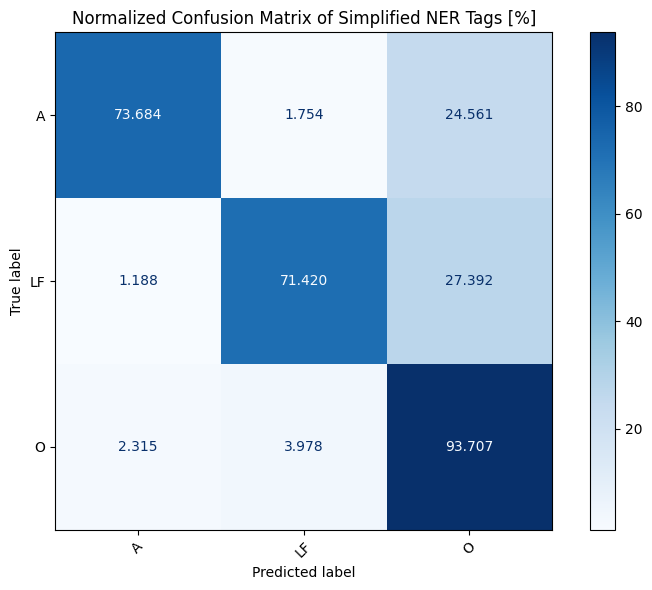

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in pred_labels for label in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".3f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()


# Experiment 3

## Load packages and dataset

In [33]:
# Load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})

In [34]:
dataset['train'][0]

{'tokens': ['MRR',
  ',',
  'mortality',
  'rate',
  'ratio',
  ';',
  'TBI',
  ',',
  'traumatic',
  'brain',
  'injury',
  '.'],
 'pos_tags': ['NOUN',
  'PUNCT',
  'NOUN',
  'NOUN',
  'NOUN',
  'PUNCT',
  'PROPN',
  'PUNCT',
  'ADJ',
  'NOUN',
  'NOUN',
  'PUNCT'],
 'ner_tags': ['B-AC',
  'O',
  'B-LF',
  'I-LF',
  'I-LF',
  'O',
  'B-AC',
  'O',
  'B-LF',
  'I-LF',
  'I-LF',
  'O']}

## Define Model & Tokenizer
### Tokenize data

In [35]:
# define model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4   # Class labels: B-AC, B-LF, I-LF, O
)

# this fucntion is to tokenize our dataset
def tokenize_and_align_labels(batch):
    tokenized = tokenizer(
        batch["tokens"],
        truncation=True,
        padding="max_length",
        max_length=128,
        is_split_into_words=True
    )

    labels = batch["ner_tags"]
    label_to_id = {"B-AC": 0, "B-LF": 1, "I-LF": 2, "O": 3}
    aligned_labels = []

    for i, label in enumerate(labels):
        word_ids = tokenized.word_ids(i)
        aligned_label = []
        for word_idx in word_ids:
            if word_idx is None:
                aligned_label.append(-100)  # for padding or special tokens
            else:
                aligned_label.append(label_to_id.get( label[min(word_idx, len(label) - 1)], -100 ))
        aligned_labels.append(aligned_label)

    tokenized["labels"] = aligned_labels
    return tokenized
# create tokenized dataset
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

/Users/darren/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Define F1 Metric function

In [36]:
metric = evaluate.load("f1")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    true_labels, true_preds = [], []
    for pred_row, label_row in zip(preds, labels):
        for p, l in zip(pred_row, label_row):
            if l != -100:  # ignore padding
                true_labels.append(l)
                true_preds.append(p)

    return metric.compute(predictions=true_preds, references=true_labels, average="weighted")

##Training Arguments

In [37]:
# define general training args
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_strategy ="epoch",
    report_to="none",
)

## Define Loss Function

In [38]:
import torch
from torch.nn import CrossEntropyLoss

# Mannually define class weights
# [B-AC, B-LF, I-LF, O]
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
class_weights = torch.tensor([9.5, 15.8, 6.5, 1]).to(device)


# define custom trainer subclass to override loss default funtion
class CustomTrainer(Trainer):
    # Custom loss function - weighted CrossEntropyLoss
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs["labels"]

        # Flatten the logits and labels to match shape for CrossEntropyLoss
        logits = logits.view(-1, model.config.num_labels)
        labels = labels.view(-1)

        # Apply CrossEntropyLoss with class weights
        loss_fn = CrossEntropyLoss(weight=class_weights, ignore_index=-100)
        loss = loss_fn(logits, labels)

        if return_outputs:
            return loss, outputs
        else:
            return loss

# Experiment Setup-1
Optimizer = Adam

In [39]:
from torch.optim import Adam, AdamW

# Define optimizers
optimizer1 = Adam(model.parameters(), lr=1e-5)
optimizer2 = AdamW(model.parameters(), lr=1e-5)

### Default Trainer Class:
 * Loss Function - Cross Entropy Loss
 * Optimizer - Adam

In [40]:
# Init default trainer - Cross Entropy loss, Adam Optimizer
trainer1_cross = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer1, None) #custom optimizer
)
trainer1_cross.train()

/Users/darren/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.507100,0.373157,0.872432
2,0.289000,0.343856,0.882323
3,0.247900,0.338716,0.886979
4,0.225500,0.346491,0.887894
5,0.214800,0.348309,0.888195


TrainOutput(global_step=1250, training_loss=0.29686031799316404, metrics={'train_runtime': 162.7681, 'train_samples_per_second': 61.437, 'train_steps_per_second': 7.68, 'total_flos': 326644561920000.0, 'train_loss': 0.29686031799316404, 'epoch': 5.0})

In [41]:
trainer1_cross.evaluate(eval_dataset=tokenized_dataset["test"])

{'eval_loss': 0.2499864250421524,
 'eval_f1': 0.9090825749713641,
 'eval_runtime': 1.2202,
 'eval_samples_per_second': 204.877,
 'eval_steps_per_second': 26.224,
 'epoch': 5.0}

F1 Score: 0.7552805632600811
              precision    recall  f1-score   support

          AC       0.71      0.82      0.76       587
          LF       0.70      0.81      0.75      1581

   micro avg       0.70      0.82      0.76      2168
   macro avg       0.70      0.82      0.76      2168
weighted avg       0.70      0.82      0.76      2168



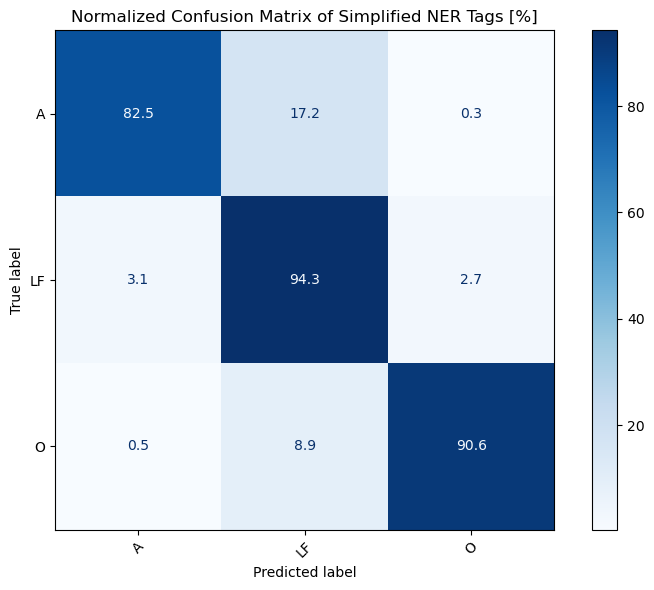

In [43]:
predictions, labels, _ = trainer1_cross.predict(tokenized_dataset["validation"])
label_list = ["O", "B-AC", "B-LF", "I-LF"]
preds = np.argmax(predictions, axis=-1)

true_labels = []
true_predictions = []

for pred_seq, label_seq in zip(preds, labels):
    true_seq = []
    pred_seq_clean = []
    for p, l in zip(pred_seq, label_seq):
        if l != -100:
            true_seq.append(label_list[l])
            pred_seq_clean.append(label_list[p])
    true_labels.append(true_seq)
    true_predictions.append(pred_seq_clean)
    
print("F1 Score:", f1_score(true_labels, true_predictions))
print(classification_report(true_labels, true_predictions))

flat_true = [tag for seq in true_labels for tag in seq]
flat_pred = [tag for seq in true_predictions for tag in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".1f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()

### Custom Trainer Class:
  * Loss Function - Weighted Cross Entropy Loss
  * Optimizer - Adam

In [44]:
# Init custom trainer - Weighted Cross Entropy loss, Adam Optimizer
trainer1_crossW = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer1, None) #custom optimizer
)
trainer1_crossW.train()

/Users/darren/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.206900,0.367884,0.868625
2,0.155100,0.417662,0.876024
3,0.133300,0.413483,0.880111
4,0.120200,0.443915,0.882266
5,0.113100,0.449586,0.881487


TrainOutput(global_step=1250, training_loss=0.14570045928955078, metrics={'train_runtime': 203.8243, 'train_samples_per_second': 49.062, 'train_steps_per_second': 6.133, 'total_flos': 326644561920000.0, 'train_loss': 0.14570045928955078, 'epoch': 5.0})

In [45]:
trainer1_crossW.evaluate(eval_dataset=tokenized_dataset["test"])

{'eval_loss': 0.3013457953929901,
 'eval_f1': 0.9063185763811185,
 'eval_runtime': 1.2374,
 'eval_samples_per_second': 202.037,
 'eval_steps_per_second': 25.861,
 'epoch': 5.0}

F1 Score: 0.7477403451109286
              precision    recall  f1-score   support

          AC       0.67      0.88      0.76       587
          LF       0.68      0.82      0.74      1581

   micro avg       0.67      0.84      0.75      2168
   macro avg       0.67      0.85      0.75      2168
weighted avg       0.67      0.84      0.75      2168



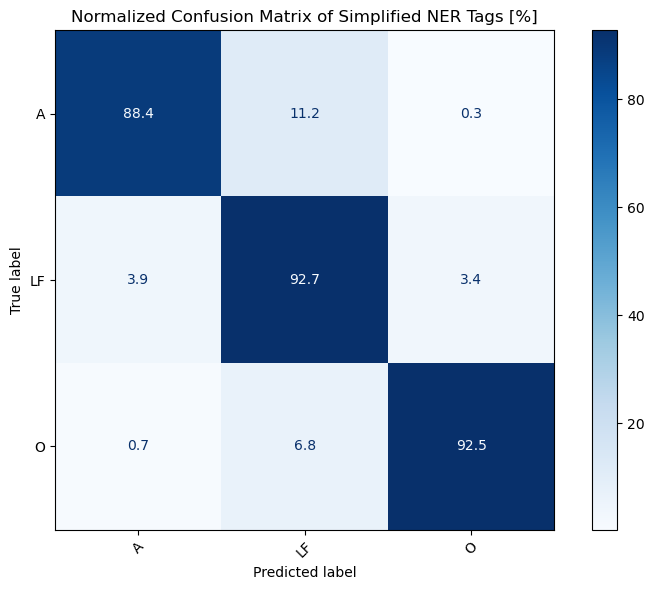

In [46]:
predictions, labels, _ = trainer1_crossW.predict(tokenized_dataset["validation"])
label_list = ["O", "B-AC", "B-LF", "I-LF"]
preds = np.argmax(predictions, axis=-1)

true_labels = []
true_predictions = []

for pred_seq, label_seq in zip(preds, labels):
    true_seq = []
    pred_seq_clean = []
    for p, l in zip(pred_seq, label_seq):
        if l != -100:
            true_seq.append(label_list[l])
            pred_seq_clean.append(label_list[p])
    true_labels.append(true_seq)
    true_predictions.append(pred_seq_clean)
    
    
print("F1 Score:", f1_score(true_labels, true_predictions))
print(classification_report(true_labels, true_predictions))

flat_true = [tag for seq in true_labels for tag in seq]
flat_pred = [tag for seq in true_predictions for tag in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".1f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()

# Experiment Setup-2
Optimizer = AdamW

### Default Trainer Class:
  * Loss Function - Cross Entropy Loss
  * Optimizer - AdamW

In [47]:
# Init second default trainer - Cross Entropy loss, AdamW Optimizer
trainer2_cross = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer2, None) #custom optimizer
)
trainer2_cross.train()

/Users/darren/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.152900,0.396957,0.884982
2,0.121200,0.422151,0.886259
3,0.106600,0.425927,0.890866
4,0.095200,0.466381,0.889282
5,0.095100,0.464262,0.887481


TrainOutput(global_step=1250, training_loss=0.11419610748291016, metrics={'train_runtime': 168.78, 'train_samples_per_second': 59.249, 'train_steps_per_second': 7.406, 'total_flos': 326644561920000.0, 'train_loss': 0.11419610748291016, 'epoch': 5.0})

In [48]:
trainer2_cross.evaluate(eval_dataset=tokenized_dataset["test"])

{'eval_loss': 0.292071133852005,
 'eval_f1': 0.910158294043187,
 'eval_runtime': 1.0906,
 'eval_samples_per_second': 229.225,
 'eval_steps_per_second': 29.341,
 'epoch': 5.0}

F1 Score: 0.7557663289502048
              precision    recall  f1-score   support

          AC       0.72      0.82      0.77       587
          LF       0.70      0.80      0.75      1581

   micro avg       0.71      0.81      0.76      2168
   macro avg       0.71      0.81      0.76      2168
weighted avg       0.71      0.81      0.76      2168



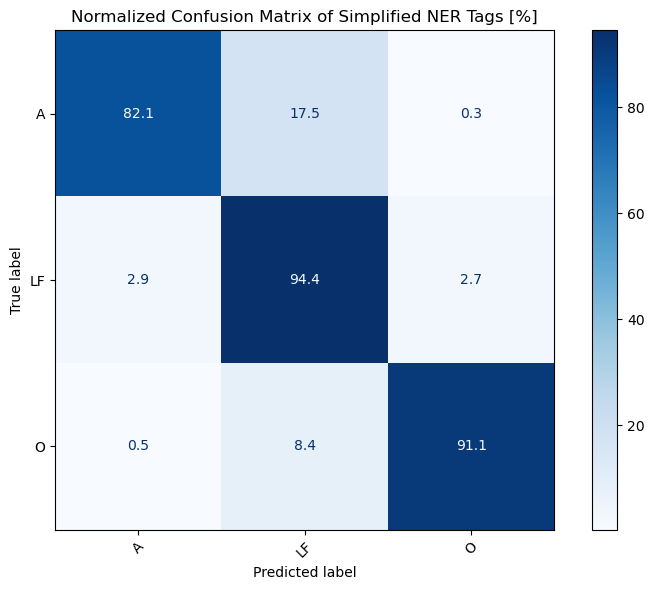

In [49]:
predictions, labels, _ = trainer2_cross.predict(tokenized_dataset["validation"])
label_list = ["O", "B-AC", "B-LF", "I-LF"]
preds = np.argmax(predictions, axis=-1)

true_labels = []
true_predictions = []

for pred_seq, label_seq in zip(preds, labels):
    true_seq = []
    pred_seq_clean = []
    for p, l in zip(pred_seq, label_seq):
        if l != -100:
            true_seq.append(label_list[l])
            pred_seq_clean.append(label_list[p])
    true_labels.append(true_seq)
    true_predictions.append(pred_seq_clean)
    
print("F1 Score:", f1_score(true_labels, true_predictions))
print(classification_report(true_labels, true_predictions))

flat_true = [tag for seq in true_labels for tag in seq]
flat_pred = [tag for seq in true_predictions for tag in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".1f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()

### Custom Trainer Class:
  * Loss Function - Weighted Cross Entropy Loss
  * Optimizer - AdamW

In [50]:
# Init second custom trainer - Weighted Cross Entropy loss, AdamW Optimizer
trainer2_crossW = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer2, None) #custom optimizer
)
trainer2_crossW.train()

/Users/darren/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.058700,0.680321,0.882313
2,0.049000,0.673493,0.887158
3,0.044600,0.656719,0.889153
4,0.049300,0.686448,0.885918
5,0.051400,0.685214,0.884980


TrainOutput(global_step=1250, training_loss=0.05059431762695313, metrics={'train_runtime': 208.4967, 'train_samples_per_second': 47.962, 'train_steps_per_second': 5.995, 'total_flos': 326644561920000.0, 'train_loss': 0.05059431762695313, 'epoch': 5.0})

In [51]:
trainer2_crossW.evaluate(eval_dataset=tokenized_dataset["test"])

{'eval_loss': 0.4562422037124634,
 'eval_f1': 0.9104385826812383,
 'eval_runtime': 1.0819,
 'eval_samples_per_second': 231.068,
 'eval_steps_per_second': 29.577,
 'epoch': 5.0}

F1 Score: 0.7606819616922752
              precision    recall  f1-score   support

          AC       0.70      0.87      0.78       587
          LF       0.70      0.82      0.76      1581

   micro avg       0.70      0.83      0.76      2168
   macro avg       0.70      0.85      0.77      2168
weighted avg       0.70      0.83      0.76      2168



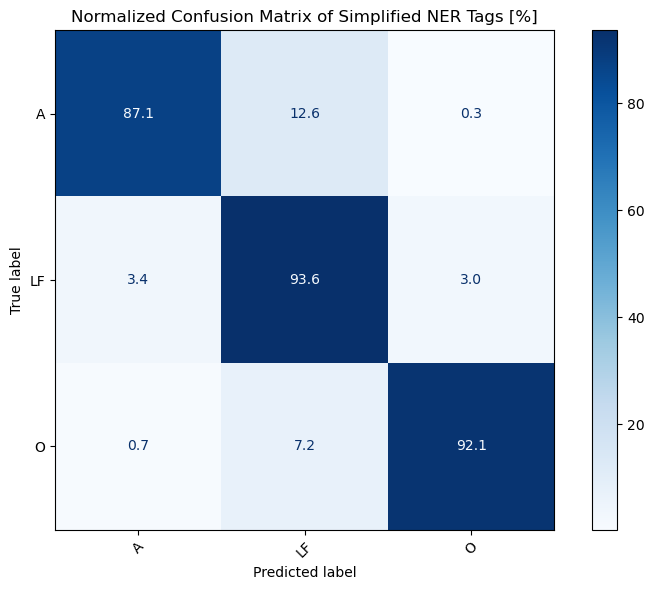

In [52]:
predictions, labels, _ = trainer2_crossW.predict(tokenized_dataset["validation"])
label_list = ["O", "B-AC", "B-LF", "I-LF"]
preds = np.argmax(predictions, axis=-1)

true_labels = []
true_predictions = []

for pred_seq, label_seq in zip(preds, labels):
    true_seq = []
    pred_seq_clean = []
    for p, l in zip(pred_seq, label_seq):
        if l != -100:
            true_seq.append(label_list[l])
            pred_seq_clean.append(label_list[p])
    true_labels.append(true_seq)
    true_predictions.append(pred_seq_clean)
    

print("F1 Score:", f1_score(true_labels, true_predictions))
print(classification_report(true_labels, true_predictions))

flat_true = [tag for seq in true_labels for tag in seq]
flat_pred = [tag for seq in true_predictions for tag in seq]

def simplify(tag):
    if tag == "B-AC":
        return "A"
    elif tag in ("B-LF", "I-LF"):
        return "LF"
    else:
        return "O"

flat_true_simplified = [simplify(tag) for tag in flat_true]
flat_pred_simplified = [simplify(tag) for tag in flat_pred]

le = LabelEncoder()
le.fit(["A", "LF", "O"])
y_true_encoded = le.transform(flat_true_simplified)
y_pred_encoded = le.transform(flat_pred_simplified)

cm = confusion_matrix(y_true_encoded, y_pred_encoded, normalize='true') * 100

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", ax=ax, values_format=".1f", xticks_rotation=45)
plt.title("Normalized Confusion Matrix of Simplified NER Tags [%]")
plt.tight_layout()
plt.show()

# Save and Upload Best Model

In [ ]:
from huggingface_hub import login

login()  # Paste

In [ ]:
MODEL_PATH = "mdlam/distilbert-ner-classification"

model.save_pretrained("./distilbert-ner-classification")
tokenizer.save_pretrained("./distilbert-ner-classification")

model.push_to_hub(MODEL_PATH)
tokenizer.push_to_hub(MODEL_PATH)